# Deep Learining Project 2
###    Wojciech Wieczorek 145465
###    Jerzy Łukaszewicz 145458

For each class, there is one pattern occurring in the data. Solving just a classification task be scored no higher than 70%. 

Please provide either pdf with the report or add some notes in the notebook. Demonstrate some examples of how your approach works.

A short reminder of your task:
 - Correct classification of provided time series
 - Explanation of the prediction

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [20]:
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, RepeatVector, TimeDistributed, Reshape, Permute, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import Sequence, plot_model
import tensorflow.keras.backend as K
import tensorflow as tf

In [4]:
np.random.seed(42)

In [5]:
n = 50000

In [6]:
def createRow(n, classes):
    base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),n))
    if classes[0] > 0:
        base[np.random.randint(0,n), 0] += 2
    if classes[1] > 0:
        base[np.random.randint(0,n), 1] -= 2
    if classes[2] > 0:
        x = np.random.randint(0,n-5)
        base[x:x+4,2] = 0
    if classes[3] > 0:
        x = np.random.randint(0,n-10)
        base[x:x+8,1] += 1.5
    if classes[4] > 0:
        x = np.random.randint(0,n-7)
        base[x:x+6,0] += 1.5
        base[x:x+6,2] -= 1.5
    base += np.random.rand(*base.shape)*.2
    return base

In [7]:
xl, yl = [], []
for _ in range(n):
    cl = np.random.rand(5)<.25
    xl.append(createRow(np.random.randint(40,60), cl))
    yl.append(cl)  

[False False False False  True]


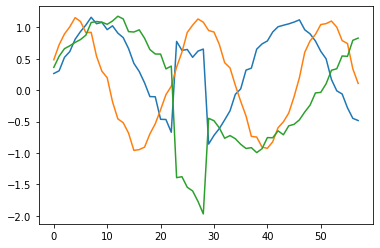

[False False False  True  True]


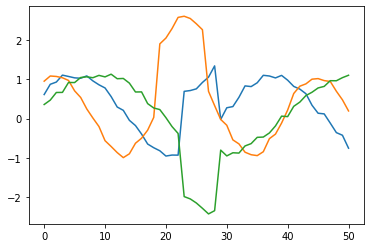

[False False False False False]


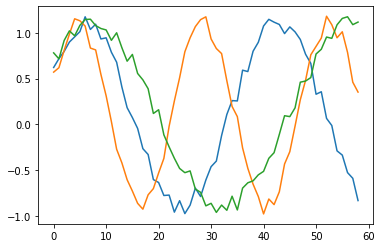

In [8]:
for i in range(3):
    plt.plot(xl[i])
    print(yl[i])
    plt.show()

In [28]:
padded_xl = tf.keras.preprocessing.sequence.pad_sequences(
    xl, padding="post",dtype='float32', maxlen=60
)

In [29]:
padded_xl.shape

(50000, 60, 3)

In [30]:
padded_xl = np.array(padded_xl)
new_yl = np.array(yl).astype(int)

#### Split sizes: 
* 80% - train
* 10% - validation
* 10% - test

In [31]:
X_train, X_test, y_train, y_test = train_test_split(padded_xl, new_yl, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [13]:
model = Sequential()
model.add(Input(shape=(None, 3)))
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(32,return_sequences=False))
model.add(Dense(5,activation='sigmoid'))
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 64)          17408     
                                                                 
 lstm_1 (LSTM)               (None, None, 32)          12416     
                                                                 
 lstm_2 (LSTM)               (None, None, 32)          8320      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 46,629
Trainable params: 46,629
Non-trainable params: 0
_________________________________________________________________


In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
model.fit(X_train,y_train, epochs=25, validation_data = (X_val, y_val), batch_size=64,verbose=1, callbacks=[callback])

Epoch 1/25
625/625 [==============================] - 35s 49ms/step - loss: 0.3686 - recall: 0.3784 - precision: 0.9440 - val_loss: 0.2753 - val_recall: 0.5486 - val_precision: 0.9670
Epoch 2/25
625/625 [==============================] - 30s 48ms/step - loss: 0.2525 - recall: 0.6110 - precision: 0.9495 - val_loss: 0.2136 - val_recall: 0.6589 - val_precision: 0.9842
Epoch 3/25
625/625 [==============================] - 30s 48ms/step - loss: 0.2092 - recall: 0.6666 - precision: 0.9737 - val_loss: 0.2054 - val_recall: 0.6656 - val_precision: 0.9858
Epoch 4/25
625/625 [==============================] - 29s 47ms/step - loss: 0.1909 - recall: 0.6961 - precision: 0.9738 - val_loss: 0.1715 - val_recall: 0.7207 - val_precision: 0.9884
Epoch 5/25
625/625 [==============================] - 29s 47ms/step - loss: 0.1740 - recall: 0.7319 - precision: 0.9665 - val_loss: 0.1504 - val_recall: 0.7632 - val_precision: 0.9843
Epoch 6/25
625/625 [==============================] - 29s 46ms/step - loss: 0.15

In [24]:
model.evaluate(X_test,y_test)

157/157 [==============================] - 2s 13ms/step - loss: 0.0146 - recall: 0.9872 - precision: 0.9967


[0.014599783346056938, 0.9871694445610046, 0.9966824650764465]

In [17]:
model.save("model_numero_uno")

INFO:tensorflow:Assets written to: model_numero_uno\assets


INFO:tensorflow:Assets written to: model_numero_uno\assets


In [43]:
model.predict(np.array([X_test[12]])).round()

array([[0., 0., 1., 0., 0.]], dtype=float32)

[0 0 1 0 0]


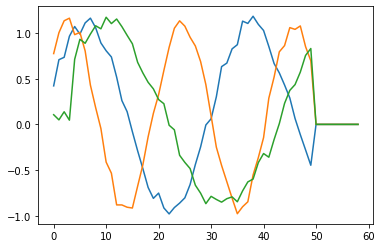

In [42]:
plt.plot(X_test[12])
print(y_test[12])

In [38]:
miniModel = Sequential()
miniModel.add(LSTM(64, return_sequences=True, input_shape=(10, 3)))
miniModel.add(LSTM(32, return_sequences=True))
miniModel.add(LSTM(32, return_sequences=True))
miniModel.add(LSTM(32, return_sequences=False))
miniModel.add(Dense(5, activation='sigmoid'))
miniModel.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 10, 64)            17408     
                                                                 
 lstm_21 (LSTM)              (None, 10, 32)            12416     
                                                                 
 lstm_22 (LSTM)              (None, 10, 32)            8320      
                                                                 
 lstm_23 (LSTM)              (None, 32)                8320      
                                                                 
 dense_5 (Dense)             (None, 5)                 165       
                                                                 
Total params: 46,629
Trainable params: 46,629
Non-trainable params: 0
_________________________________________________________________


In [61]:
pred_model = Sequential()
pred_model.add(Reshape((-1, 10, 3), input_shape=(60, 3)))
pred_model.add(TimeDistributed(miniModel))
pred_model.add(GlobalMaxPool1D())
pred_model.compile('adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])
pred_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_8 (Reshape)         (None, 6, 10, 3)          0         
                                                                 
 time_distributed_7 (TimeDis  (None, 6, 5)             46629     
 tributed)                                                       
                                                                 
 global_max_pooling1d_5 (Glo  (None, 5)                0         
 balMaxPooling1D)                                                
                                                                 
Total params: 46,629
Trainable params: 46,629
Non-trainable params: 0
_________________________________________________________________


In [63]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
pred_model.fit(X_train,y_train, epochs=5, validation_data = (X_val, y_val), batch_size=64, verbose=1, callbacks=[callback])

Epoch 1/5
625/625 [==============================] - 44s 71ms/step - loss: 0.0048 - binary_accuracy: 0.9986 - val_loss: 0.0127 - val_binary_accuracy: 0.9968
Epoch 2/5
625/625 [==============================] - 40s 64ms/step - loss: 0.0051 - binary_accuracy: 0.9986 - val_loss: 0.0069 - val_binary_accuracy: 0.9982
Epoch 3/5
625/625 [==============================] - 38s 61ms/step - loss: 0.0044 - binary_accuracy: 0.9987 - val_loss: 0.0122 - val_binary_accuracy: 0.9968
Epoch 4/5
625/625 [==============================] - 38s 61ms/step - loss: 0.0046 - binary_accuracy: 0.9986 - val_loss: 0.0095 - val_binary_accuracy: 0.9971
Epoch 5/5
625/625 [==============================] - 38s 61ms/step - loss: 0.0033 - binary_accuracy: 0.9990 - val_loss: 0.0084 - val_binary_accuracy: 0.9977


In [65]:
model2 = Model(inputs=pred_model.layers[0].input, outputs=pred_model.layers[-2].output)
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_8_input (InputLayer  [(None, 60, 3)]          0         
 )                                                               
                                                                 
 reshape_8 (Reshape)         (None, 6, 10, 3)          0         
                                                                 
 time_distributed_7 (TimeDis  (None, 6, 5)             46629     
 tributed)                                                       
                                                                 
Total params: 46,629
Trainable params: 46,629
Non-trainable params: 0
_________________________________________________________________


In [75]:
colors = model2.predict(X_val)
colors[0].round()

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [76]:
y_val[0]

array([1, 0, 0, 1, 0])

In [80]:
len(pom[0])

55

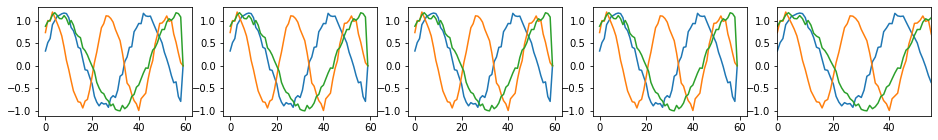

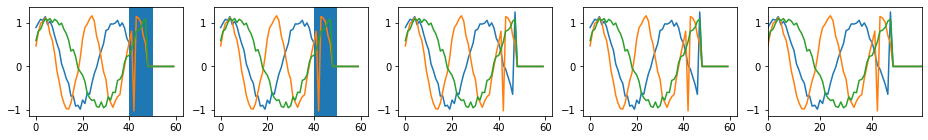

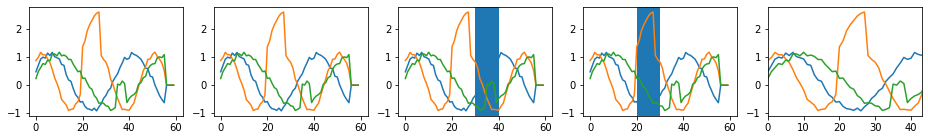

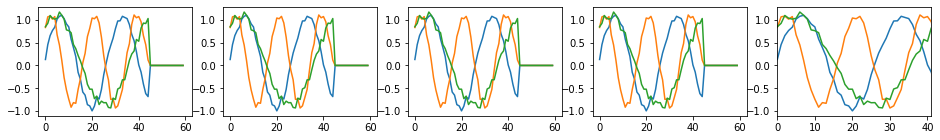

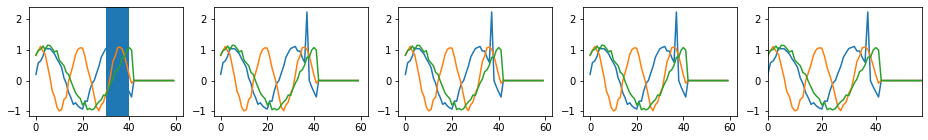

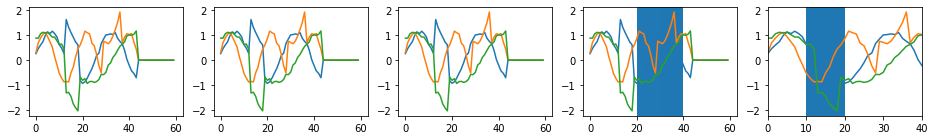

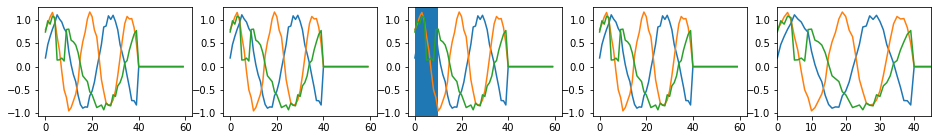

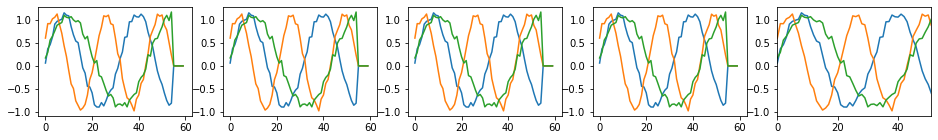

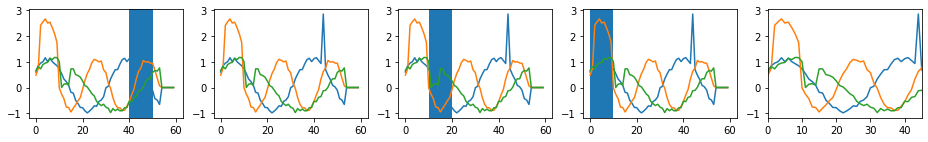

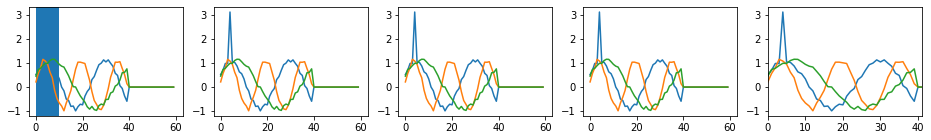

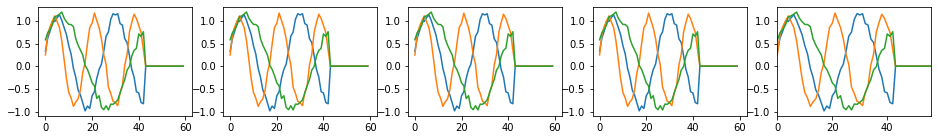

In [82]:
#n = 5
data = X_val[100:111]
pom = xl[100:111]
perdictions = model2.predict(data) 

for idx, p in enumerate(perdictions):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (16,2))
    
    ax1.plot(data[idx])
    for i in range(6):
        ax1.axvspan(i*10, i*10+10, alpha=p[i, 0])
    
    ax2.plot(data[idx])
    for i in range(6):
        ax2.axvspan(i*10, i*10+10, alpha=p[i, 1])
    
    ax3.plot(data[idx])
    for i in range(6):
        ax3.axvspan(i*10, i*10+10, alpha=p[i, 2])
    
    ax4.plot(data[idx])
    for i in range(6):
        ax4.axvspan(i*10, i*10+10, alpha=p[i, 3])
    
    ax5.plot(data[idx])
    ax5.set_xlim([0, len(pom[idx])])
    for i in range(6):
        ax5.axvspan(i*10, i*10+10, alpha=p[i, 4])
    
    
    plt.show()

In [118]:
X_train, X_test, y_train, y_test = train_test_split(padded_xl, new_yl, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [119]:
X_train, X_test, y_train, y_test = train_test_split(xl, new_yl, test_size=0.2, random_state=42)
X_test, X_val_nonpad, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [120]:
data = X_val[102:109]
pom = X_val_nonpad[102:109]

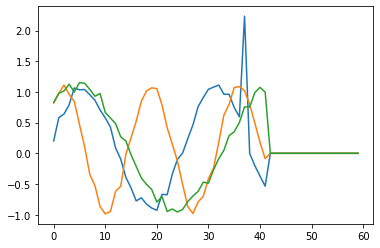

In [121]:
plt.plot(data[2])
plt.show()

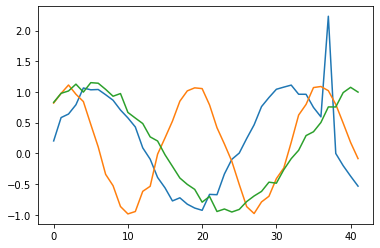

In [122]:
plt.plot(pom[2])
plt.show()

In [103]:
xl[104]

array([[ 0.42348429,  0.705202  ,  0.88788908],
       [ 0.63985667,  0.96663516,  0.96698582],
       [ 0.70033367,  0.99220921,  1.00503764],
       [ 0.97724076,  1.18534293,  1.07736365],
       [ 1.00008425,  1.145919  ,  1.01892536],
       [ 1.01012236,  1.06522113,  1.1637711 ],
       [ 1.18560579,  0.87939027,  1.15903893],
       [ 1.16916648,  0.75785444,  1.06461467],
       [ 1.09864295,  0.52952237,  1.09688264],
       [ 1.04414269,  0.33364257,  0.97548024],
       [ 0.91042157,  0.02195925,  0.9499314 ],
       [ 0.92307935, -0.29566312,  0.92563009],
       [ 0.77064787, -0.56185501,  0.92183792],
       [ 0.55848135, -0.76212939,  0.85294355],
       [ 0.28732361, -0.80426646,  0.58676921],
       [ 0.12018456, -0.80753005,  0.62609858],
       [-0.03152163, -0.87214397,  0.52076471],
       [-0.06762757, -0.84668914,  0.42481107],
       [-0.3109291 , -0.68343136,  0.32092935],
       [-0.51935624, -0.61275257,  0.07146776],
       [-0.66998865, -0.37142821,  0.029

0


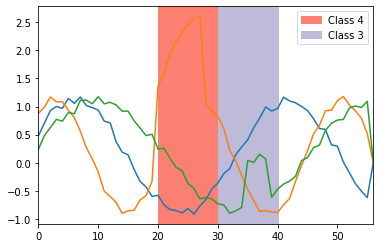

1


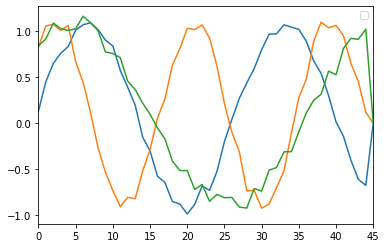

2


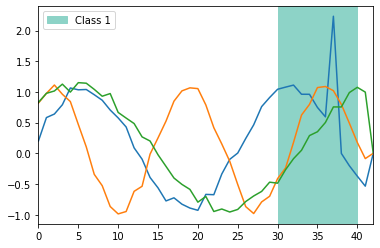

3


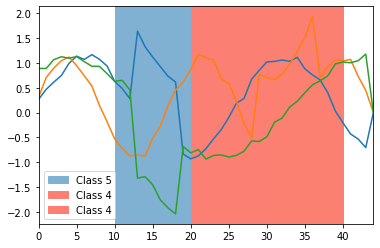

4


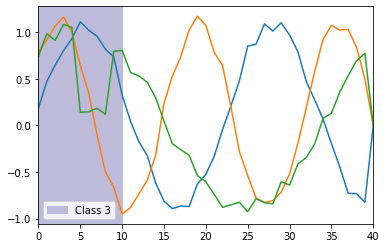

5


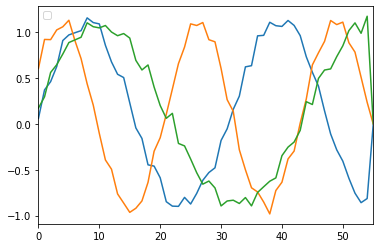

6


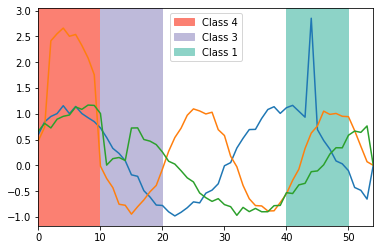

In [112]:
#n = 5
data = X_val[102:109]
pom = X_val_nonpad[102:109]
perdictions = model2.predict(data) 

for idx, p in enumerate(perdictions):
    print(idx)
    plt.figure()
    plt.plot(data[idx])
    for i in range(6):
        if p[i, 0].round() > 0:
            plt.axvspan(i*10, i*10+10, alpha=p[i, 0], color=(141/255, 211/255, 199/255), label="Class 1")
        if p[i, 1].round() > 0:
            plt.axvspan(i*10, i*10+10, alpha=p[i, 1], color=(255/255, 255/255, 179/255), label="Class 2")
        if p[i, 2].round() > 0:
            plt.axvspan(i*10, i*10+10, alpha=p[i, 2], color=(190/255, 186/255, 218/255), label="Class 3")
        if p[i, 3].round() > 0:
            plt.axvspan(i*10, i*10+10, alpha=p[i, 3], color=(251/255, 128/255, 114/255), label="Class 4")
        if p[i, 4].round() > 0:
            plt.axvspan(i*10, i*10+10, alpha=p[i, 4], color=(128/255, 177/255, 211/255), label="Class 5")
    
    plt.xlim([0, len(pom[idx])])
    plt.legend()
    plt.show()

In [47]:
# x = tf.permute(X_test[12], (3, 59))
# x

AttributeError: module 'tensorflow' has no attribute 'permute'

In [52]:
# import tensorflow.keras.layers as layers

In [61]:
# p = layers.Permute((2, 1), input_shape=(59, 3))(np.array([X_test[12]]))
# p

<tf.Tensor: shape=(1, 3, 59), dtype=float32, numpy=
array([[[ 0.42176628,  0.7084701 ,  0.73479253,  0.9653744 ,
          1.0718521 ,  0.9889491 ,  1.1114684 ,  1.1634527 ,
          1.0587381 ,  0.8919814 ,  0.80634385,  0.738403  ,
          0.5178304 ,  0.26083156,  0.13905208, -0.07999301,
         -0.28917915, -0.4852053 , -0.690729  , -0.8099742 ,
         -0.75232387, -0.91491663, -0.9803869 , -0.91077477,
         -0.86212116, -0.8043506 , -0.6582289 , -0.439209  ,
         -0.24673083, -0.00658045,  0.06155264,  0.3025762 ,
          0.6327385 ,  0.6713228 ,  0.8269797 ,  0.8728292 ,
          1.1306844 ,  1.1057019 ,  1.1843796 ,  1.0953289 ,
          1.028472  ,  0.8534083 ,  0.6671438 ,  0.56387806,
          0.4314429 ,  0.28919718,  0.06443393, -0.11216541,
         -0.27878737, -0.44739237,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.77546585,  1.0038623 ,  1.1349481

In [60]:
# X_test[12].shape

(59, 3)

In [17]:
# model = Sequential()
# model.add(Input(shape=(59, 3)))
# model.add(LSTM(64,return_sequences=True))
# model.add(LSTM(32,return_sequences=True))
# model.add(LSTM(32,return_sequences=True))
# model.add(LSTM(32,return_sequences=False))
# model.add(Dense(5,activation='sigmoid'))
# model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
# model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 59, 64)            17408     
                                                                 
 lstm_5 (LSTM)               (None, 59, 32)            12416     
                                                                 
 lstm_6 (LSTM)               (None, 59, 32)            8320      
                                                                 
 lstm_7 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 46,629
Trainable params: 46,629
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# input_layer = Input(shape=(59, 1))
# lstm = LSTM(64, return_sequences=True)(input_layer)
# lstm = LSTM(32, return_sequences=True)(lstm)
# lstm = LSTM(32, return_sequences=True)(lstm)
# lstm = LSTM(32, return_sequences=False)(lstm)
# out = Dense(5, 'sigmoid')(lstm)

In [94]:
# input_sequence = Input(shape=(59,3))

# permute = Permute((2, 1))(input_sequence)

# DynamicInput = Input(shape=(None, 1))
# lstm = LSTM(64, return_sequences=True)(DynamicInput)
# lstm = LSTM(32, return_sequences=True)(lstm)
# lstm = LSTM(32, return_sequences=True)(lstm)
# lstm = LSTM(32, return_sequences=False)(lstm)
# out = Dense(5, 'sigmoid')(lstm)

# model = Model([DynamicInput], out)

# m0 = model(permute[:, 0])
# m1 = model(permute[:, 1])
# m2 = model(permute[:, 2])
# concat = tf.keras.layers.Concatenate(axis=0)([m0, m1, m2])
# #f = Flatten()(concat)
# #pool = GlobalMaxPool1D(concat)

# m = Model([input_sequence], concat)
# m.compile('adam', loss='binary_crossentropy', metrics='acc')
# m.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 59, 3)]      0                                            
__________________________________________________________________________________________________
permute_29 (Permute)            (None, 3, 59)        0           input_32[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.getitem_48 (Sl (None, 59)           0           permute_29[0][0]                 
__________________________________________________________________________________________________
tf.__operators__.getitem_49 (Sl (None, 59)           0           permute_29[0][0]                 
___________________________________________________________________________________________

In [70]:
# m = Sequential()
# m.add(Permute((2, 1), input_shape=(59, 3)))

# #m.add(TimeDistributed(model))
# m.add(GlobalMaxPool1D())
# m.compile('adam', loss='binary_crossentropy', metrics='acc')
# m.summary()

ValueError: Input 0 of layer sequential_14 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 59)